In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd
from shapely.geometry import Point


%load_ext autoreload
%autoreload 2
sns.set()
%matplotlib inline

## Using Space, Time, Length, Weigth, Abundance, Maturity, Quarter

In [2]:
#First inspect data
file_dir = '/Users/markrademaker/Projects/Spatio_temporal_clustering/Data/'
df = pd.read_csv(file_dir+'Gadus_morhua_1991_2019_length_weight_cpue.csv')
#df = pd.read_csv(file_dir+'Gadus_morhua_1977_2019_length_weight_cpue.csv')
print(df.head())
print('n observations ='+str(len(df)))

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1   Survey  Year  Quarter  \
0           0             0           49398  NS-IBTS  1991        1   
1           1             1           49399  NS-IBTS  1991        1   
2           2             2           49400  NS-IBTS  1991        1   
3           3             3           49401  NS-IBTS  1991        1   
4           4             4           49402  NS-IBTS  1991        1   

   YearQuarter                DateTime  ShootLat  ShootLong  LngtClass_cm  \
0            1  07-01-1991 03:19:00 PM   51.0833     2.0333          25.0   
1            1  07-01-1991 03:19:00 PM   51.0833     2.0333          48.0   
2            1  07-01-1991 03:19:00 PM   51.0833     2.0333          49.0   
3            1  07-01-1991 03:19:00 PM   51.0833     2.0333          50.0   
4            1  07-01-1991 03:19:00 PM   51.0833     2.0333          53.0   

   CPUE_number_per_hour  Biomass_kg  Maturity  Biomass_gram  LngtClass_cm_log  \
0                   2.0    0.

[61.8833 -0.3   ]
[49.6013  0.0831]
Max_dist_spatial = 12.287973372773882
Max_dist_time = 57
Max_dist_length = 140.0
Max_dist_CPUE = 6708.18
Max_dist_biomass_gram = 258037.05104543126


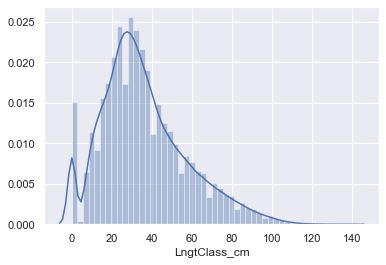

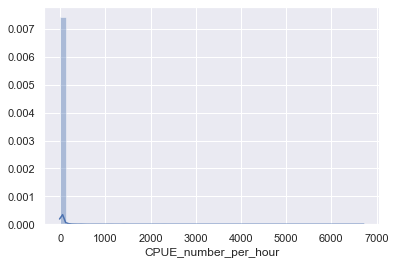

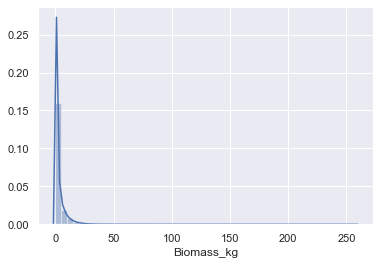

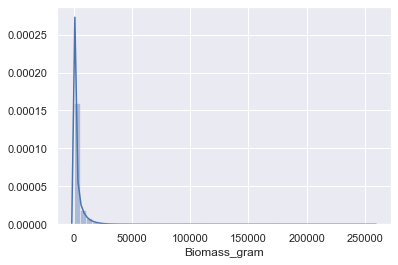

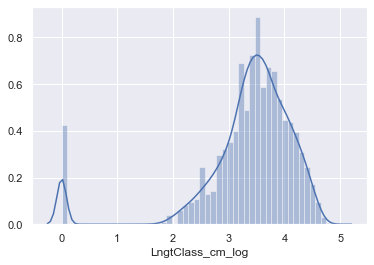

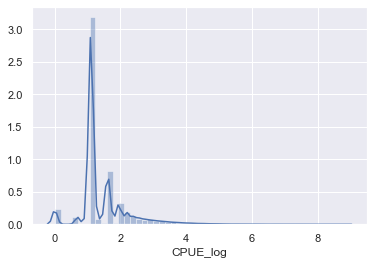

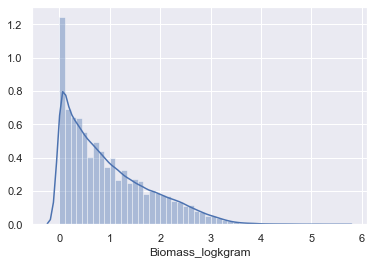

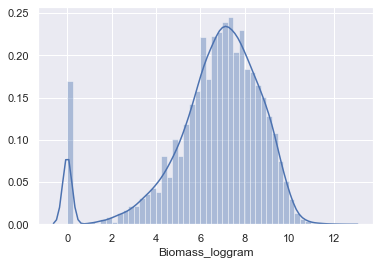

In [3]:
from scipy import spatial
#value range for normalizing
#lat_lon_dist. for normalizing
max_lat_id = df['ShootLat'].argmax()
min_lat_id = df['ShootLat'].argmin()

arr_max =np.array([df['ShootLat'][max_lat_id],df['ShootLong'][max_lat_id]])
arr_min =np.array([df['ShootLat'][min_lat_id],df['ShootLong'][min_lat_id]])
print(arr_max)
print(arr_min)

max_dist_spatial = spatial.distance.euclidean(arr_max,arr_min) #euclidean distance between min and max for normalizing
print('Max_dist_spatial = '+str(max_dist_spatial))

max_dist_time = max(df['YearQuarter'])-min(df['YearQuarter'])#absolute difference for normalizing
print('Max_dist_time = '+str(max_dist_time))


max_dist_length = max(df['LngtClass_cm'])-min(df['LngtClass_cm']) #absolute difference for normalizing
print('Max_dist_length = '+str(max_dist_length))

max_dist_CPUE = max(df['CPUE_number_per_hour'])-min(df['CPUE_number_per_hour']) #absolute max. difference for normalizing
print('Max_dist_CPUE = '+str(max_dist_CPUE))


max_dist_biomass_gram = max(df['Biomass_gram'])-min(df['Biomass_gram']) #absolute max. difference for normalizing
print('Max_dist_biomass_gram = '+str(max_dist_biomass_gram))

max_dist_quarter = max(df['Quarter'])-min(df['Quarter']) #absolute max. difference for normalizing

max_dist_maturity = max(df['Maturity'])-min(df['Maturity']) #absolute max. difference for normalizing

#frequency plots of attributes
sns.distplot(df['LngtClass_cm']) 
plt.show()

sns.distplot(df['CPUE_number_per_hour']) 
plt.show()

sns.distplot(df['Biomass_kg']) 
plt.show()

sns.distplot(df['Biomass_gram']) 
plt.show()

#df['LngtClass_cm_log']=np.log(df['LngtClass_cm']+1)
sns.distplot(df['LngtClass_cm_log'])
plt.show()

#df['CPUE_log']=np.log(df['CPUE_number_per_hour']+1)
sns.distplot(df['CPUE_log'])
plt.show()

#df['Biomass_logkgram']=np.log(df['Biomass_kg']+1)
sns.distplot(df['Biomass_logkgram'])
plt.show()

#df['Biomass_loggram']=np.log(df['Biomass_gram']+1)
sns.distplot(df['Biomass_loggram'])
plt.show()

In [4]:
from sthc import STHC
params = {"distance":{"fieldnames":{"x":"ShootLong","y":"ShootLat"},
                      "function": lambda x,y: spatial.distance.cdist([x],y),#divided by max spatial dist 
                      "normalize_n": [max_dist_spatial], "normalize_k":None,"normalize_mean": False, "weights":1.0}, #Euclidean distance between two points, normalized by the maximum distance in dataset
          
           # Try YearQuarter time distance -> still absolute measure
          "timedistance":{"fieldnames":{"datetime":"YearQuarter"},
                          "function": lambda x,y: np.abs(x-y),
                          "normalize_n": [max_dist_time], "normalize_k":None,"normalize_mean": False, "weights":1.0}, #Absolute difference between two points, normalized by the maximum difference in dataset
          
          "attributes":{"fieldnames":["LngtClass_cm","CPUE_number_per_hour","Biomass_gram","Maturity","Quarter"],
                        "function": [lambda x,y: np.log(np.abs(x-y)+1),#LngtClass
                                     lambda x,y: np.log(np.abs(x-y)+1),#Catch per Unit Effort
                                     lambda x,y: np.log(np.abs(x-y)+1),#Biomass in grams
                                     lambda x,y: np.abs(x-y),#Maturity
                                     lambda x,y: np.abs(x-y),#Quarter
                                    ],
                        "normalize_n":[np.log(max_dist_length+1),np.log(max_dist_CPUE+1),np.log(max_dist_biomass_gram+1),max_dist_maturity,max_dist_quarter],
                        "normalize_k": [None,None,None,None,None],
                        "normalize_mean": [False,False,False,False,False], "weights":[1.0,1.0,1.0,1.0,1.0]}} #(Log of) Absolute difference between two values, normalized by (Log of) maximum difference in the dataset


In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/markrademaker/Projects/Spatio_temporal_clustering/Script/sthc_mark.py'))
if module_path not in sys.path:
    sys.path.append(module_path)
from sthc_mark import STHC

file_dir ='/Users/markrademaker/Projects/Spatio_temporal_clustering/'

st = STHC()

st.load_dataset_csv('/Users/markrademaker/Projects/Spatio_temporal_clustering/Data/Gadus_morhua_1991_2019_length_weight_cpue.csv',
                    params,toepsg=4326,sample=15000)

Reading the file...
ShootLong
ShootLat
Processing table for datetime and coordinates...
Preparing attribute normalization....


In [6]:
from scipy import spatial
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

linkage_methods=['single','complete','average','weighted','centroid','median','ward']
for method in linkage_methods:
    st.calculate_distance_matrix()
    st.calculate_clusters(method=method)

single Cophenetic correlation coeffficient = 0.5025178647670119
complete Cophenetic correlation coeffficient = 0.6542524407347063
average Cophenetic correlation coeffficient = 0.6594620113181915
weighted Cophenetic correlation coeffficient = 0.6432035201241288
centroid Cophenetic correlation coeffficient = 0.6629450105665141
median Cophenetic correlation coeffficient = 0.5323916167594432
ward Cophenetic correlation coeffficient = 0.634699006422269


In [7]:
#recalculate distance with best performing method and plot results
st.calculate_clusters(method='average')

average Cophenetic correlation coeffficient = 0.6594620113181915


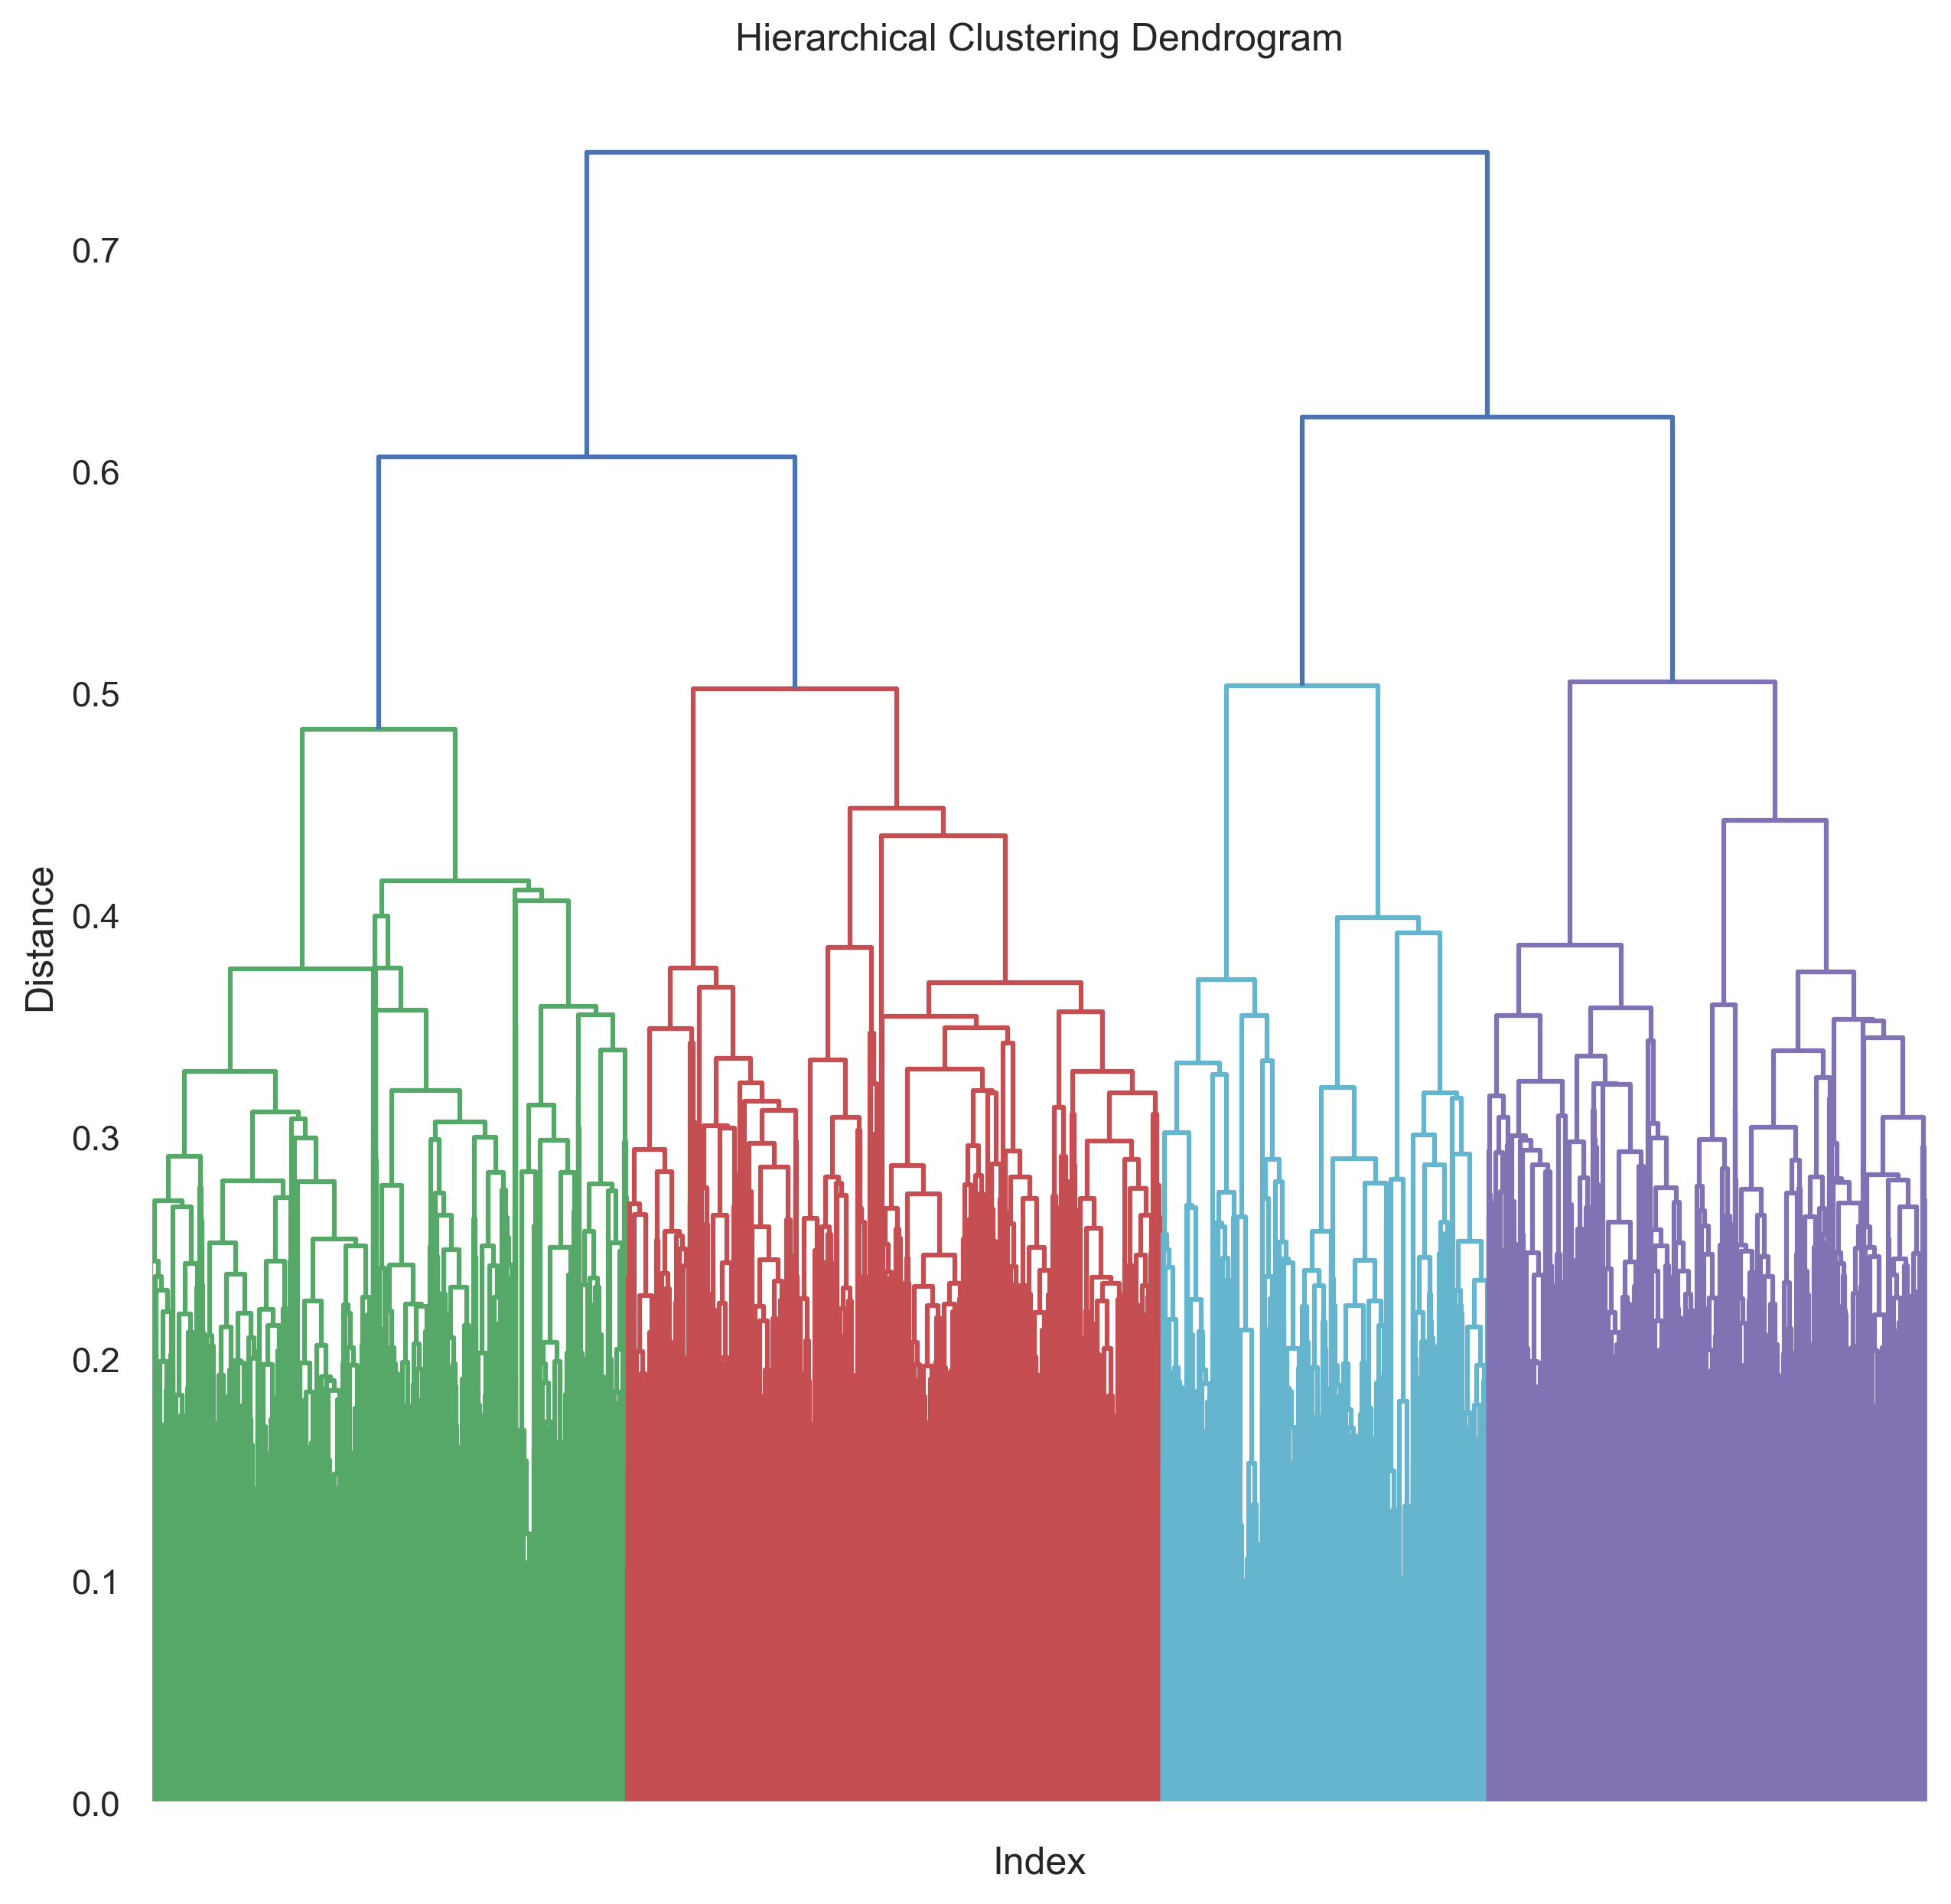

In [8]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

fig = plt.figure(figsize=(10,10),dpi=300)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
row_dendr = dendrogram(st.row_clusters)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.show()


In [9]:
a = st.silhoutte_scores_n_clusters()

1processed
2processed
For n_clusters =2
The average silhouette_score is : 0.34434892590363864
3processed
For n_clusters =3
The average silhouette_score is : 0.30399341481571746
4processed
For n_clusters =4
The average silhouette_score is : 0.30993094664965165
5processed
For n_clusters =5
The average silhouette_score is : 0.28073710307646704
6processed
For n_clusters =6
The average silhouette_score is : 0.3164054377660727
7processed
For n_clusters =7
The average silhouette_score is : 0.2868938000847837
8processed
For n_clusters =8
The average silhouette_score is : 0.29250608325081884
9processed
For n_clusters =9
The average silhouette_score is : 0.3024139437749891
10processed
For n_clusters =10
The average silhouette_score is : 0.28027746129721764
11processed
For n_clusters =11
The average silhouette_score is : 0.29196088603848874
12processed
For n_clusters =12
The average silhouette_score is : 0.303642775458379
13processed
For n_clusters =13
The average silhouette_score is : 0.29486786

In [10]:
#recalculate distance with wards
st.calculate_clusters(method='ward')

ward Cophenetic correlation coeffficient = 0.634699006422269


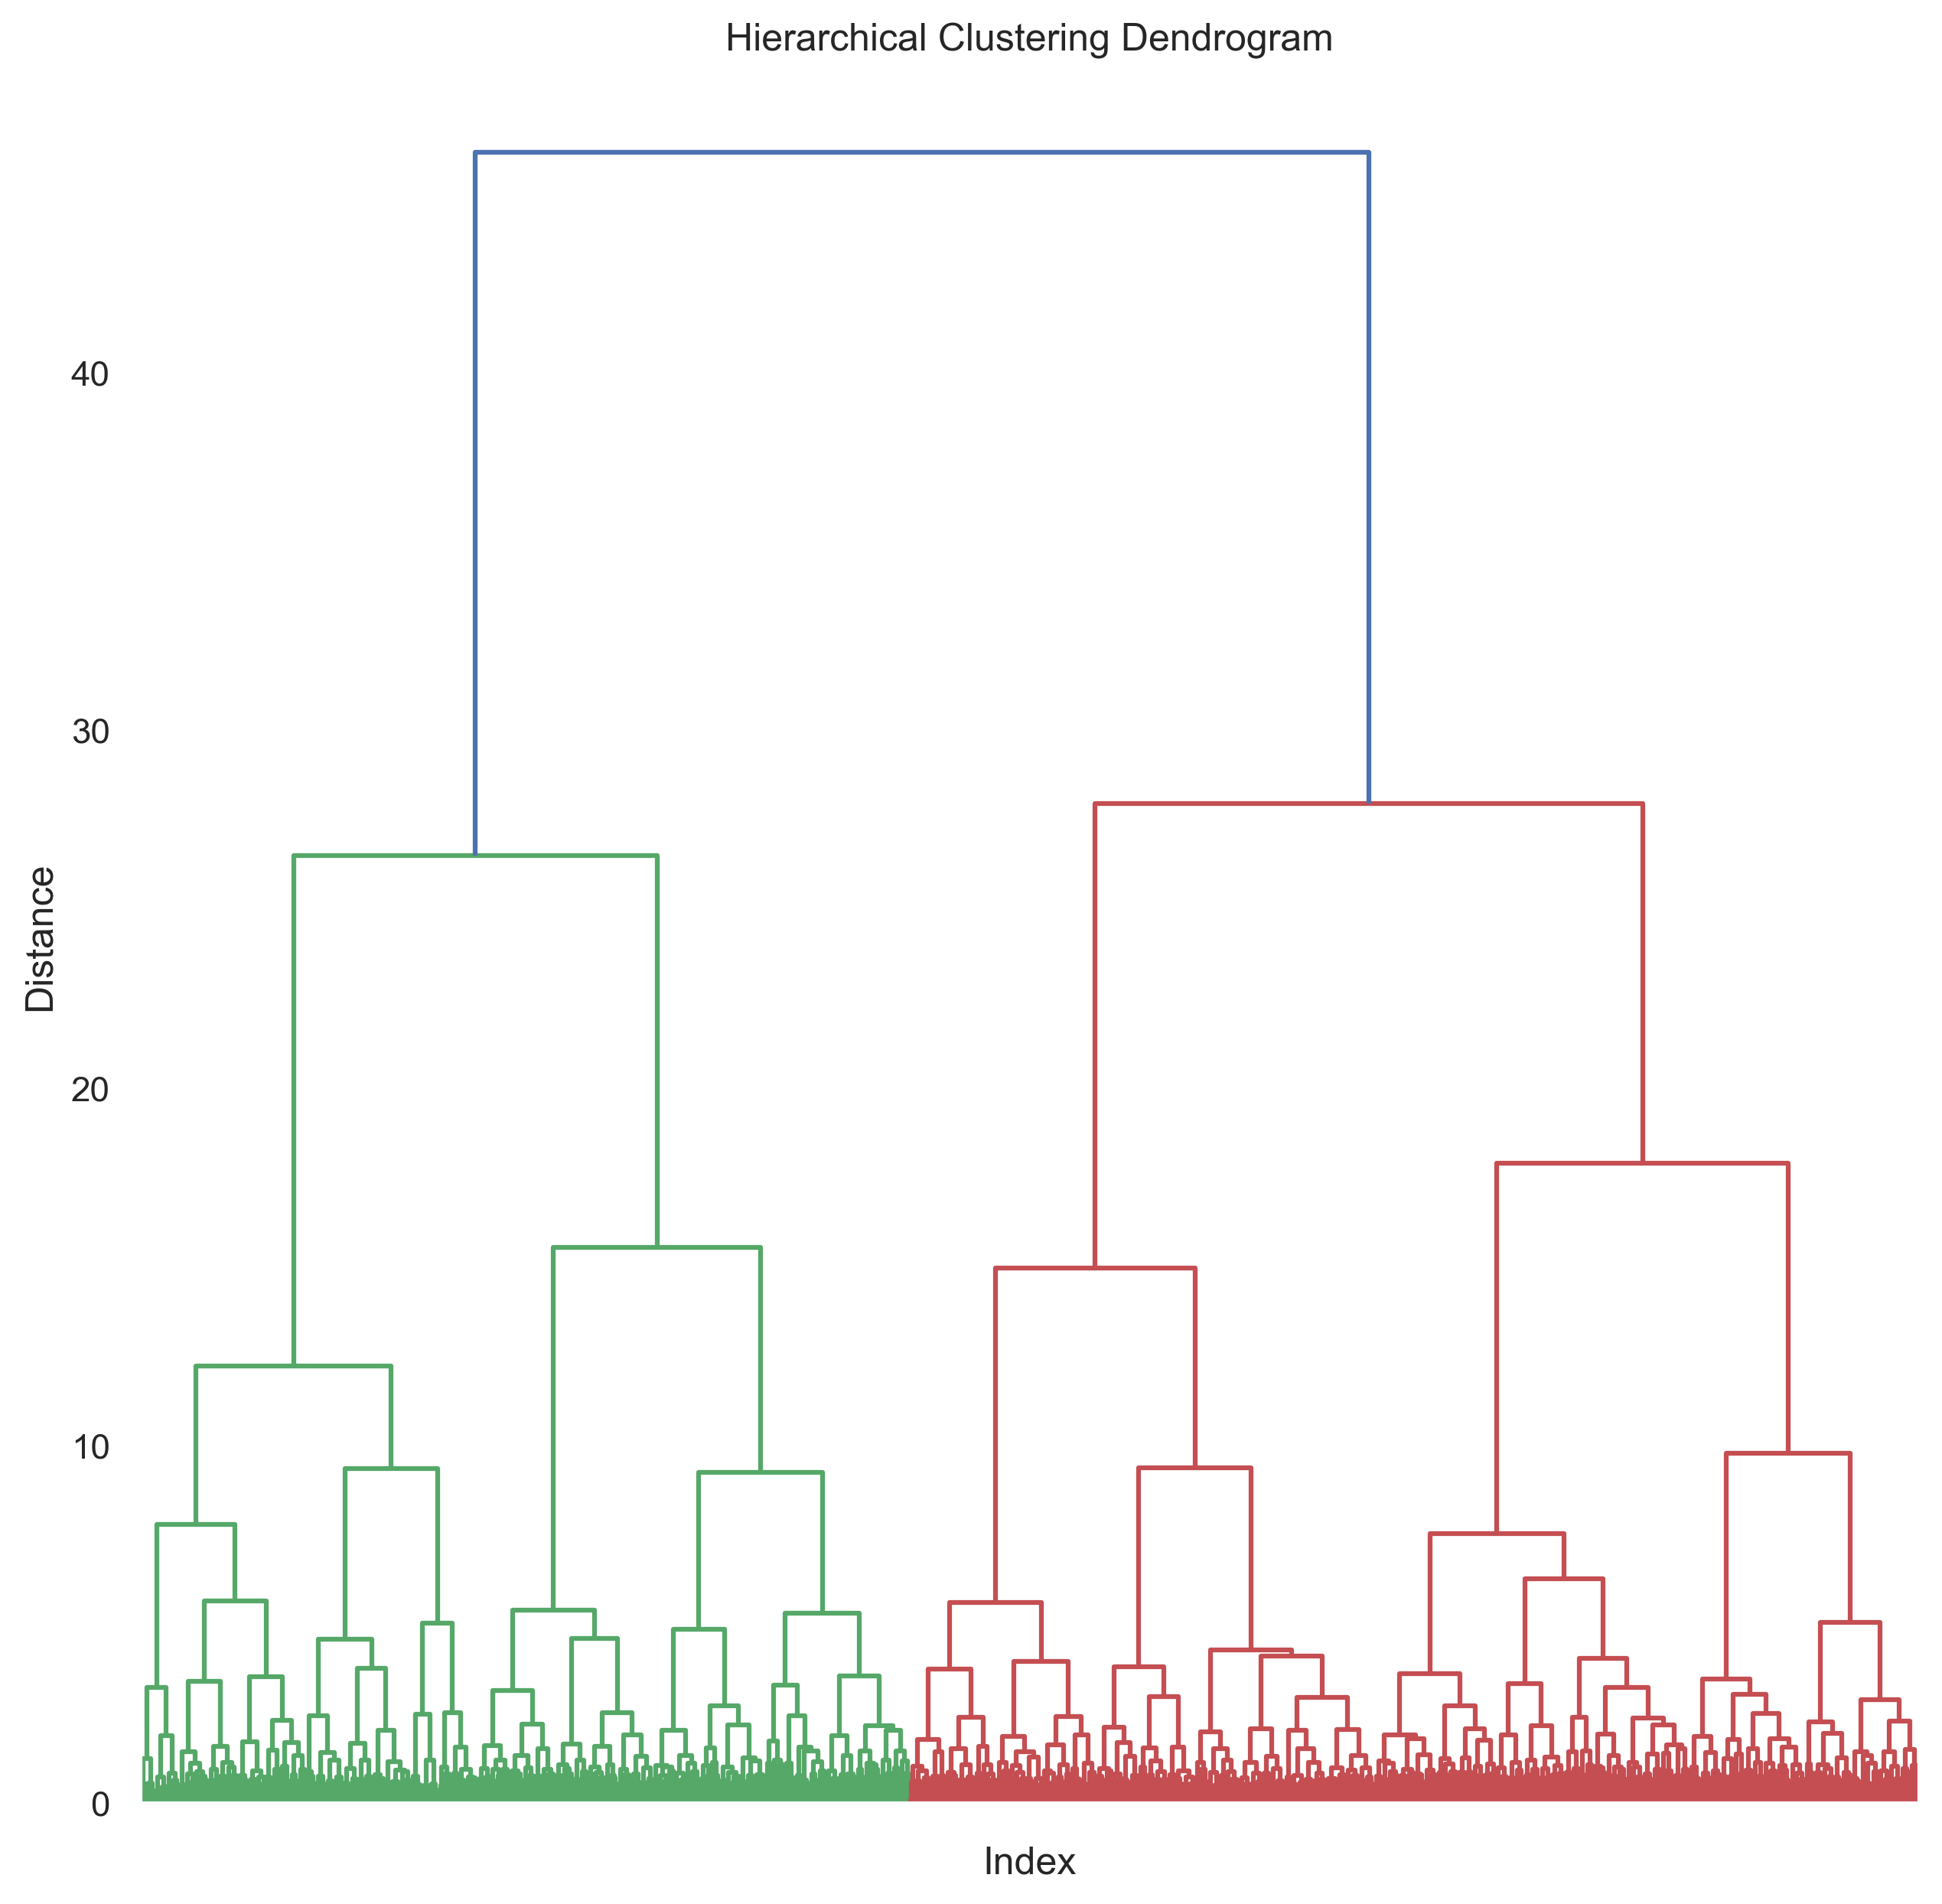

In [11]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

fig = plt.figure(figsize=(10,10),dpi=300)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
row_dendr = dendrogram(st.row_clusters)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.show()


In [12]:
a = st.silhoutte_scores_n_clusters()

1processed
2processed
For n_clusters =2
The average silhouette_score is : 0.30966046749718246
3processed
For n_clusters =3
The average silhouette_score is : 0.2842801987113272
4processed
For n_clusters =4
The average silhouette_score is : 0.29657308789557724
5processed
For n_clusters =5
The average silhouette_score is : 0.29313617650760954
6processed
For n_clusters =6
The average silhouette_score is : 0.29495553880702713
7processed
For n_clusters =7
The average silhouette_score is : 0.30240062818265256
8processed
For n_clusters =8
The average silhouette_score is : 0.2963406200880013
9processed
For n_clusters =9
The average silhouette_score is : 0.2976495641736267
10processed
For n_clusters =10
The average silhouette_score is : 0.29850685525854526
11processed
For n_clusters =11
The average silhouette_score is : 0.29588994611788416
12processed
For n_clusters =12
The average silhouette_score is : 0.30325375712230107
13processed
For n_clusters =13
The average silhouette_score is : 0.299868

In [ ]:
#code snippet for clustering per year

df['clusterYear'] = -1
for year in df['Year'].unique():
    print(year)
    dfyear = df[df['Year'] == year].copy()
    filename = "temp.csv"
    print(len(dfyear))
    dfyear.to_csv(filename)
    st = STHC()

 

    st.load_dataset_csv(filename,
                    params,toepsg=4326,sample=None)
    
    st.calculate_distance_matrix()
    
    st.calculate_clusters_hdbscan()
    print(np.unique(st.row_clusters.labels_))
    df.loc[df['Year']==year,'clusterYear'] = st.row_clusters.labels_
    del dfyear
    del st
    break #remove this when you want to run for all the years

 


gdf = gpd.GeoDataFrame(df[df['Year'] ==1991],geometry=df[df['Year'] ==1991][['ShootLong','ShootLat']].apply(lambda x: Point(x),axis=1))
gdf.plot(column='clusterYear');